### Вводная:
Трафовые пользователи - пользователи, привлеченные нами в результате рекламных кампаний, т.е. за каждого из них заплачено Х денег
Органические пользователи - пришли в проект сами, т.е. они для нас бесплатные
Есть подозрение, что часть органики приходит от купленного трафа (посредством внутренних виральных инструментов игры, word of mouth или какими-то другими способами).
Количество человек, пришедших с каждого пользователя будем условно называть "k-фактором".


#### Задача 1: 
- посчитать k-фактор от трафовых пользователей

#### Задача 2: 
- если k-фактор отличен от 0, посчитать “k-фактор” для денег - т.е. сколько дополнительно денег приходит на каждый потраченный доллар трафового пользователя от привлеченной трафом органики

#### Задача 3: 
- творческая. Если что-то интересное придет в голову или будет найдена полезная закономерность в данных - это приветствуется.

#### Цель: правильно оценить эффективность маркетинговых кампаний

Данные:
ms - канал привлечения (ORGANIC/UA)
cohort - дата привледения
user_cnt - количество новых пользователей
gross - сколько эти пользователи заплатили


#### Импортируем необходимые библиотеки для решения поставленных задач

In [315]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

import requests
from urllib.parse import urlencode



Используем функцию ydisk, для загрузки данных по API.

In [316]:
def ydisk(public_key, sep=None):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    if sep: 
        df = pd.read_csv(download_url, sep=';')
    else:
        df = pd.read_csv(download_url)
    return df

#### Выгружаем данные

In [317]:
df_test = 'https://disk.yandex.ru/d/Wuhqs3MUEMprGw'
df = ydisk(df_test)

In [318]:
df.describe()

,user_cnt,gross
count,1462.000000,1462.000000
mean,6201.270862,516.803010
std,4058.405863,449.168427
min,2085.000000,12.000000
25%,3763.000000,229.000000
50%,4723.000000,418.500000
75%,7253.250000,698.750000
max,41110.000000,8214.000000


In [320]:
df.head()

,ms,cohort,user_cnt,gross
0,ORGANIC,2016-01-01,3676,1510
1,UA,2016-01-01,6061,686
2,UA,2016-01-02,6542,1179
3,ORGANIC,2016-01-02,3875,565
4,ORGANIC,2016-01-03,3699,425


В нашем случае, имея только суммарное количество трафовых и органических пользователей в день, мы можем сделать лишь косвенные предположения о влиянии трафика на привлечение новых пользователей.

Используем два подхода для оценки влияния "k-фактора":

#### 1. Анализ корреляции:

    * Построим графики изменения количества трафовых пользователей и органических пользователей по дням.
    * Посмотрим, есть ли в графиках видимая корреляция.  
    * Если рост количества трафовых пользователей сопровождается ростом количества органических пользователей, это может говорить о том, что трафик оказывает влияние на привлечение органики.

In [321]:
# Создание новой таблицы с количеством новых пользователей и выручкой по каналам привлечения
new_df = df.pivot_table(index='cohort', columns='ms', values=['user_cnt', 'gross'], aggfunc='sum')
new_df.columns = [f'{col[1]}_{col[0]}' for col in new_df.columns]
new_df.reset_index(inplace=True)
new_df.head()

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
0,2016-01-01,1510,686,3676,6061
1,2016-01-02,565,1179,3875,6542
2,2016-01-03,425,1186,3699,6260
3,2016-01-04,1161,718,3237,5330
4,2016-01-05,917,1308,2792,5027


In [322]:
new_df.describe()

,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
count,731.000000,731.000000,731.000000,731.000000
mean,528.759234,504.846785,4707.459644,7695.082079
std,455.184716,443.059257,2152.880856,4884.662254
min,12.000000,13.000000,2326.000000,2085.000000
25%,268.000000,190.000000,3549.000000,4176.500000
50%,456.000000,377.000000,4222.000000,6538.000000
75%,711.000000,673.000000,5186.000000,9643.500000
max,8214.000000,4178.000000,22057.000000,41110.000000


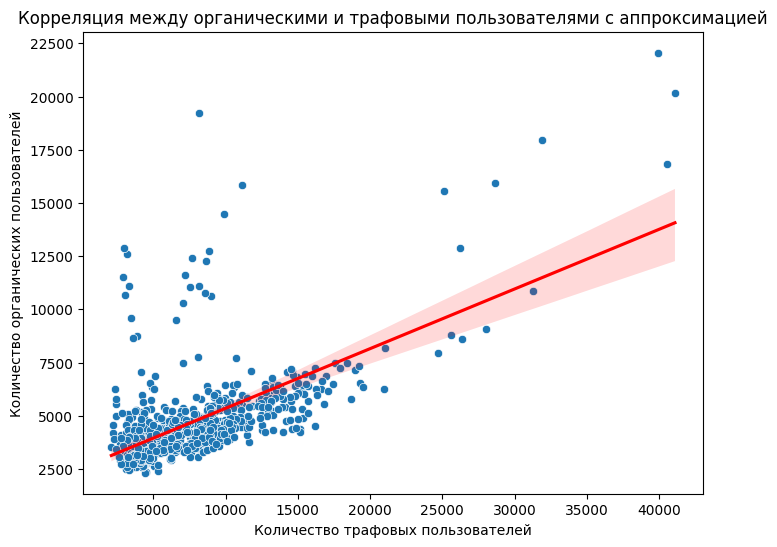

In [323]:
# Построение графика корреляции между ORGANIC_user_cnt и UA_user_cnt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UA_user_cnt', y='ORGANIC_user_cnt', data=new_df)
sns.regplot(x='UA_user_cnt', y='ORGANIC_user_cnt', data=new_df, scatter=False, color='red')
plt.title('Корреляция между органическими и трафовыми пользователями с аппроксимацией')
plt.ylabel('Количество органических пользователей')
plt.xlabel('Количество трафовых пользователей')
plt.show()

In [324]:
# Вычисление коэффициента корреляции Пирсона
correlation = new_df['ORGANIC_user_cnt'].corr(new_df['UA_user_cnt'])
correlation

0.6356162942958982

В данных присутствуют выбросы, используем более устойчивую к ним меру корреляции, воспользуемся ранговой корреляцией Спирмена 

In [325]:
# Вычисление корреляции Спирмена
spearman_corr = new_df['ORGANIC_user_cnt'].corr(new_df['UA_user_cnt'], method='spearman')
print(f'Корреляция Спирмена между ORGANIC_user_cnt и UA_user_cnt: {spearman_corr}')

Корреляция Спирмена между ORGANIC_user_cnt и UA_user_cnt: 0.6429175078365315


#### Вывод:
Значение коэффициента корреляции Спирмена = 0.643, указывает на наличие положительной монотонной связи между количеством органических пользователей и трафовых пользователей. 

Таким образом, рост трафовых пользователей сопровождается ростом количества органических пользователей, это может говорить о том, что трафик оказывает влияние на привлечение органики. 

Следовательно: подозрение, что часть органики приходит от купленного трафа верна!

#### 2. Сравнение периодов с разным объемом трафика:

    * Выберем периоды с разным объемом трафовых пользователей (например, дни с высокой активностью рекламных кампаний и дни с низкой активностью).
    * Сравним среднее количество органических пользователей в эти периоды.
    * Если в периоды с высоким трафиком среднее количество органических пользователей выше, это может косвенно указывать на влияние трафика на привлечение органики.

In [326]:
new_df.head()

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
0,2016-01-01,1510,686,3676,6061
1,2016-01-02,565,1179,3875,6542
2,2016-01-03,425,1186,3699,6260
3,2016-01-04,1161,718,3237,5330
4,2016-01-05,917,1308,2792,5027


In [327]:
# Сортировка таблицы по столбцу 'column_name' по возрастанию
sorted_df = new_df.sort_values(by='UA_user_cnt')

# Выбор 10 верхних строк
top_10 = sorted_df.head(10)

# Выбор 10 нижних строк
bottom_10 = sorted_df.tail(10)

In [328]:
top_10.ORGANIC_user_cnt.mean()

4555.9

In [329]:
top_10.sort_values('cohort')

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
361,2016-12-27,1507,208,4991,2413
362,2016-12-28,987,40,4564,2233
363,2016-12-29,902,57,5545,2386
364,2016-12-30,886,62,6271,2339
365,2016-12-31,927,74,5799,2438
368,2017-01-03,643,60,4208,2210
369,2017-01-04,343,356,3933,2297
714,2017-12-15,22,25,3237,2488
715,2017-12-16,85,20,3556,2085
716,2017-12-17,13,25,3455,2431


In [330]:
bottom_10.ORGANIC_user_cnt.mean()

14319.1

In [331]:
bottom_10

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
231,2016-08-19,858,500,8789,25624
230,2016-08-18,369,349,12869,26198
232,2016-08-20,733,656,8600,26364
233,2016-08-21,679,480,9055,28012
228,2016-08-16,695,990,15959,28646
223,2016-08-11,516,1175,10872,31311
227,2016-08-15,903,1081,17973,31931
226,2016-08-14,1104,1633,22057,39919
224,2016-08-12,576,1041,16829,40581
225,2016-08-13,1483,1233,20188,41110


#### Вывод:
Среднее значение органического трафика в периоды интенсивной рекламы существенно больше, чем в периоды низкой рекламы, что косвенно указывает на влияние трафика на привлечение органики.

Таким образом, рост трафовых пользователей сопровождается ростом количества органических пользователей, это может говорить о том, что трафик оказывает влияние на привлечение органики.

Следовательно: подозрение, что часть органики приходит от купленного трафа верна!

#### Резюмируя:
Используя два подхода для оценки влияния "k-фактора" мы убедились, что "k-фактор" отличен от 0, найдем приблизительное значение "k-фактора"

Создадим новую таблицу, где будет информация только о  трафике по дням!

In [332]:
data = new_df[['cohort', 'ORGANIC_user_cnt', 'UA_user_cnt']].copy()
data.head()

,cohort,ORGANIC_user_cnt,UA_user_cnt
0,2016-01-01,3676,6061
1,2016-01-02,3875,6542
2,2016-01-03,3699,6260
3,2016-01-04,3237,5330
4,2016-01-05,2792,5027


Для более точного анализа нужно разделить органических пользователей на две группы:

1. Органические пользователи, привлеченные платными: Те, кто пришел благодаря виральности, рекомендациям платных пользователей или другим косвенным эффектам от рекламы.
2. "Чистые" органические пользователи: Те, кто нашел приложение самостоятельно, без какого-либо влияния рекламных кампаний.

#### Проблема: У нас нет возможности точно определить, к какой группе относится каждый органический пользователь.

Проанализируем данные наглядно, построим график динамики органического и трафового пользователя:

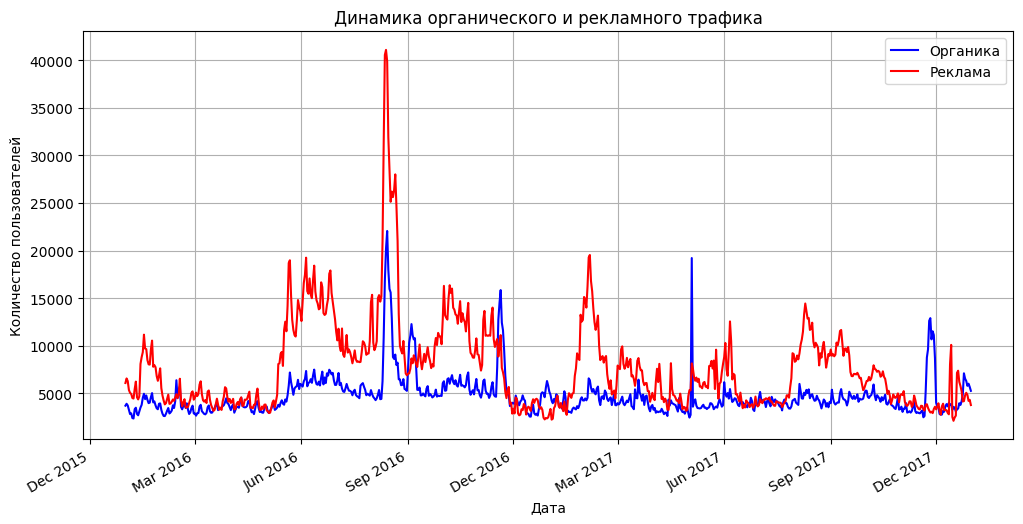

In [333]:
# Преобразование столбца 'cohort' в datetime
data['cohort'] = pd.to_datetime(data['cohort'])

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(data['cohort'], data['ORGANIC_user_cnt'], label='Органика', color='blue')
plt.plot(data['cohort'], data['UA_user_cnt'], label='Реклама', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Динамика органического и рекламного трафика')
plt.legend()
plt.grid(True)

# Форматирование оси X: отображение месяца и года
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Формат: 'Jan 2021'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Метки каждые 3 месяца
plt.gcf().autofmt_xdate() # Автоматическое форматирование и поворот меток

plt.show()

Пофиксим дневные перепады окном в неделю:

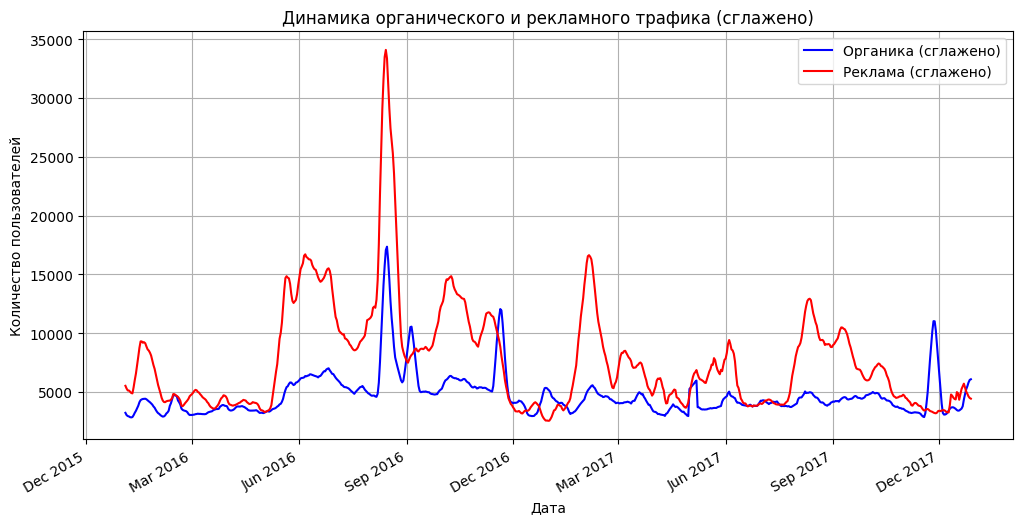

In [334]:
# Сглаживание скользящим средним (окно 7 дней)
data_smoothed = data.copy()
data_smoothed['organic_smoothed'] = data_smoothed['ORGANIC_user_cnt'].rolling(window=7, center=True).mean()
data_smoothed['paid_smoothed'] = data_smoothed['UA_user_cnt'].rolling(window=7, center=True).mean()

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(data_smoothed['cohort'], data_smoothed['organic_smoothed'], label='Органика (сглажено)', color='blue')
plt.plot(data_smoothed['cohort'], data_smoothed['paid_smoothed'], label='Реклама (сглажено)', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Динамика органического и рекламного трафика (сглажено)')
plt.legend()
plt.grid(True)

# Форматирование оси X: отображение месяца и года
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Формат: 'Jan 2021'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Метки каждые 3 месяца
plt.gcf().autofmt_xdate() # Автоматическое форматирование и поворот меток

plt.show()


Вывод: анализ динамики органического и трафового пользователя показал, что есть взаимосвязь динамики трафовых пользователей на динамику органических -- при уменьшении/увеличении трафовых пользователей происходит уменьшение/увеличение органических пользователей.

#### Резюмируя: 
Анализ взаимосвязи трафового пользователя на органического показал нам корреляцию в 0.64, так же при помощи графика -- анализа динамики пользователей, мы узнали, что есть существенная взаимосвязь.

Таким образом: чтобы вычислить приблизительный k-фактор можно расчитать дельту органики и трафовых пользователей и уже из этих данных получить k-фактор.

Отсечем самые маленькие изменения трафовых пользователей, так как  они, скорее всего, не повлияют на изменения органических пользователей, которые будут представлять собой случайные флуктуации и могут искажать расчёт k-фактора. 

Установим threshold равный 5-му квантилю, чтобы оставить 95% самых существенных изменений в рекламе.

#### Считать k-фактор по каждому дню может быть не совсем корректно,так как:
- Мы анализируем данные за длительный период;
- Возможна не линейная взаимосвязь роста трафовых и органических пользователей; 

### Задача 1: 
Посчитать k-фактор от трафовых пользователей

In [335]:
# 1. Рассчитываем ежедневные изменения
data_delta = data.copy()
data_delta['delta_organic'] = data_delta['ORGANIC_user_cnt'].diff()
data_delta['delta_paid'] = data_delta['UA_user_cnt'].diff()

# 2. Фильтруем данные 
threshold = data_delta['delta_paid'].abs().quantile(0.05) # Порог значительного изменения UA 
filtered_data = data_delta[abs(data_delta['delta_paid']) > threshold].copy()

# Суммируем абсолютные значения изменений в рекламном и органическом трафике
total_delta_paid = filtered_data['delta_paid'].abs().sum()
total_delta_organic = filtered_data['delta_organic'].abs().sum()

# 5. Рассчитываем k-фактор за весь период
k_factor = total_delta_organic / total_delta_paid


print(f"k-фактор за анализируемый период: {k_factor:.2f}")


k-фактор за анализируемый период: 0.61


Мы получили k-фактор = 0.61 за весь анализируемый период, по нему можно сказать: как трафовые пользователи влияют на привлечение органических(бесплатных) пользователей! Чем больше k-фактор, тем эффективнее реклама!

В нашем случае, в среднем, 1 трафовый пользователь приводит 0.61 дополнительных органических пользователей.

Построим график динамики изменений органики и трафовых пользователей:

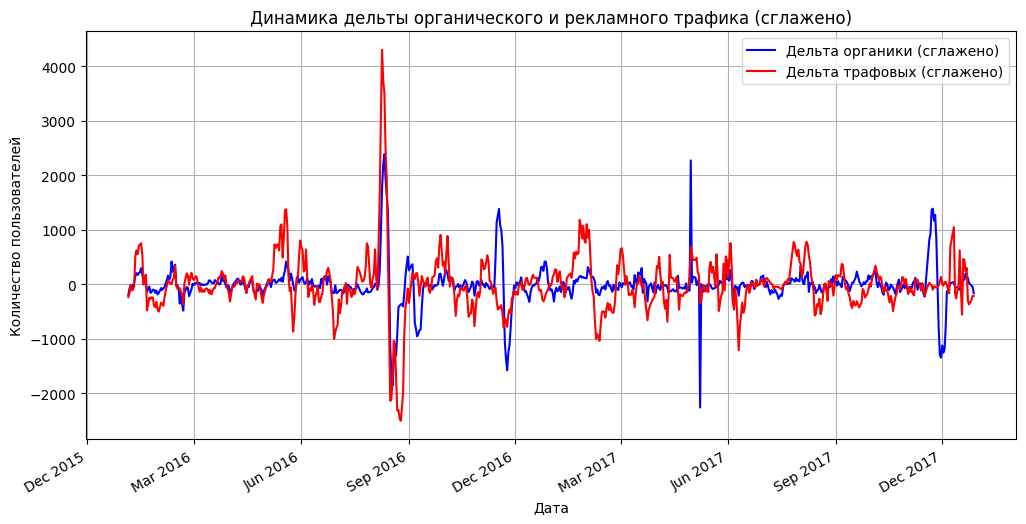

In [336]:
# Сглаживание скользящим средним (окно 7 дней)
filtered_data.loc[:, 'organic_smoothed_delta'] = filtered_data['delta_organic'].rolling(window=7, center=True).mean()
filtered_data.loc[:, 'paid_smoothed_delta'] = filtered_data['delta_paid'].rolling(window=7, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['cohort'], filtered_data['organic_smoothed_delta'], label='Дельта органики (сглажено)', color='blue')
plt.plot(filtered_data['cohort'], filtered_data['paid_smoothed_delta'], label='Дельта трафовых (сглажено)', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Динамика дельты органического и рекламного трафика (сглажено)')
plt.legend()
plt.grid(True)

# Форматирование оси X: отображение месяца и года
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Формат: 'Jan 2021'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Метки каждые 3 месяца
plt.gcf().autofmt_xdate() # Автоматическое форматирование и поворот меток

plt.show()


Важно учесть ситуации, когда снижение рекламного трафика (`delta_paid` < 0) приводит к росту органического трафика (`delta_organic` > 0) и наоборот:
 
1. Отсекаем самые маленькие изменения в рекламном трафике.
2. Исключаем случаи, когда изменение рекламного трафика и органического трафика направлены в противоположные стороны (как в ситуации "снижение рекламы + рост органики", так и в ситуации "рост рекламы + снижение органики").

Это позволит получить k-фактор, который более точно отражает ситуации, когда рекламный трафик оказывает прямое влияние на органический трафик в одном направлении.

In [337]:
# Отсекаем случаи, когда изменение рекламы и органики направлены в противоположные стороны
filtered_data_raz = filtered_data[~(((filtered_data['delta_paid'] < 0) & (filtered_data['delta_organic'] > 0)) |
                                 ((filtered_data['delta_paid'] > 0) & (filtered_data['delta_organic'] < 0)))]

# Суммируем абсолютные значения изменений в рекламном и органическом трафике
total_delta_paid = filtered_data_raz['delta_paid'].abs().sum()
total_delta_organic = filtered_data_raz['delta_organic'].abs().sum()

# Рассчитываем k-фактор за весь период
k_factor = total_delta_organic / total_delta_paid

print(f"k-фактор за весь период: {k_factor:.2f}")

k-фактор за весь период: 0.61


Таким образом, мы получили k-фактор = 0.61, который рассчитан за весь анализируемый период. 

k-фактор = 0.61, значит, что привлекая одного трафового пользователя, мы дополнительно получаем 0.61 дополнительного бесплатного органического трафика!

### Задача 2: 
Если k-фактор отличен от 0, посчитать “k-фактор” для денег - т.е. сколько дополнительно денег приходит на каждый потраченный доллар трафового пользователя от привлеченной трафом органики

In [338]:
new_df.head()

,cohort,ORGANIC_gross,UA_gross,ORGANIC_user_cnt,UA_user_cnt
0,2016-01-01,1510,686,3676,6061
1,2016-01-02,565,1179,3875,6542
2,2016-01-03,425,1186,3699,6260
3,2016-01-04,1161,718,3237,5330
4,2016-01-05,917,1308,2792,5027


In [339]:
print(f'Дата анализируемого периода с : {new_df.cohort.min()} по  {new_df.cohort.max()}')

Дата анализируемого периода с : 2016-01-01 по  2017-12-31


#### Что у нас есть?:
1. Исходные данные: У нас есть информация о количестве органических (`ORGANIC_user_cnt`) и платных (`UA_user_cnt`) пользователей, а также общая выручка с органики (`ORGANIC_gross`). 
2. k-фактор = 0.61 - за весь анализируемый период, показывает, сколько дополнительных органических пользователей привлекается на каждого платного пользователя.
3. Анализируемый период = 2 года.
4. В условиях задачи: за каждого трафового пользователя заплачено Х денег
5. Цель: Нужно понять, сколько дополнительной выручки (`k-фактор для денег`) приносит эта органика,  на каждый потраченный доллар трафового пользователя.

#### Решение:

Ключевой момент здесь - выделить вклад "вирусной" органики в общую выручку. Для этого нам нужно:

1. Оценить средний доход с одного органического пользователя;
2. Вычислить количество "вирусной" органики;
3. Рассчитать "k-фактор для денег";

In [340]:
total_paid_users = new_df['UA_user_cnt'].sum() # Сумма платных пользователей
total_organic_revenue = new_df['ORGANIC_gross'].sum() # Сумма выручки с органики

# Сумма дополнительных органичных пользователей
total_viral_organic_users = total_paid_users * k_factor 
   
# ARPU
organic_ARPU = total_organic_revenue / new_df['ORGANIC_user_cnt'].sum()

# Сумма денег, которую принисла дополнительная органика за анализируемый период
k_factor_organic_money_total = total_viral_organic_users * organic_ARPU
print(f'Сумма денег, которую принисла дополнительная органика: {k_factor_organic_money_total}')

# Суммарный расход на трафовых пользователей за анализируемый период, при цене трафового пользователя в X долларов
print(f'Суммарный расход на трафовых пользователей за анализируемый период {total_paid_users}Х, где Х - сумма денег потраченных на 1 трафового пользователя')

# Рассчитаем k-фактор для денег по второй задаче, чтобы определить, сколько приносит вирусный эффект на 1 доллар, потраченный на рекламу
raz = k_factor_organic_money_total / total_paid_users
print(f'k-фактор для денег(дополнительно денег приходит при трате на рекламу в 1 доллар) :{raz} / X, где X стоимость привлечения 1 трафового пользователя')

Сумма денег, которую принисла дополнительная органика: 383562.82889019285
Суммарный расход на трафовых пользователей за анализируемый период 5625105Х, где Х - сумма денег потраченных на 1 трафового пользователя
k-фактор для денег(дополнительно денег приходит при трате на рекламу в 1 доллар) :0.06818767452166544 / X, где X стоимость привлечения 1 трафового пользователя


#### “k-фактор” для денег 
т.е. сколько дополнительно денег приходит на каждый потраченный доллар трафового пользователя от привлеченной трафом органики, при расходах на привлечение 1 трафового пользователя = Х

`“k-фактор” для денег` за 2016-2017год = 0.06818767452166544 / X

Таким образом, если у нас есть информация, сколько стоит привлечение 1 трафового пользователя == Х, мы можем узнать, сколько доплнительно денег принесет рекламная компания от дополнительных органических пользователей,  на каждый потраченный доллар на трафового пользователя!

### Задача 3: 
Творческая, если что-то интересное придет в голову или будет найдена полезная закономерность в данных - это приветствуется.

Есть гипотеза №1, что с увеличением трафовых пользователей(при экстенсивном увеличении рекламы, K-фактор уменьшается).

Проверим данное предположение:

1. Есть данные о трафовых и органических пользователях и их дельта, filtered_data_raz - в конечной таблице при анализе выше;
2. Делим трафовых пользователей на интервалы с примерно одинаковым количеством наблюдений;
3. Расчитываем для каждого интервала K-фактор;

#### Что мы получим?:
Получим результат, где каждому сегменту будет соответствующий K-фактор. Это даст нам возможность расчитать, какой объем рекламы максимизирует дополнительный органический трафик!

In [304]:
filtered_data_raz.head()

,cohort,ORGANIC_user_cnt,UA_user_cnt,delta_organic,delta_paid,organic_smoothed_delta,paid_smoothed_delta,segment
1,2016-01-02,3875,6542,199.0,481.0,NaN,NaN,2
2,2016-01-03,3699,6260,-176.0,-282.0,NaN,NaN,1
3,2016-01-04,3237,5330,-462.0,-930.0,NaN,NaN,0
4,2016-01-05,2792,5027,-445.0,-303.0,-63.857143,-74.000000,1
6,2016-01-07,2376,4479,-492.0,-435.0,-70.000000,-31.571429,1


In [313]:
filtered_data_raz_segment = filtered_data_raz.copy()

# Делим на 5 сегментов по общему количеству платных пользователей
filtered_data_raz_segment['segment'] = pd.qcut(filtered_data_raz_segment['UA_user_cnt'], q=5, labels=False)

# Создаем DataFrame для хранения информации о сегментах
segments_info = filtered_data_raz_segment.groupby('segment')['UA_user_cnt'].agg(['min', 'max', 'count']).reset_index()
segments_info = segments_info.rename(columns={'min': 'paid_users_min', 'max': 'paid_users_max', 'count': 'observations'})

# Рассчитываем k-фактор для каждого сегмента
k_factors_by_segment = filtered_data_raz_segment.groupby('segment').apply(
    lambda x: x['delta_organic'].abs().sum() / x['delta_paid'].abs().sum()
).reset_index(name='k_factor')

# Объединяем информацию о сегментах и k-факторах
segments_info = segments_info.merge(k_factors_by_segment, on='segment')

# Выводим информацию о сегментах
print(segments_info[['segment', 'paid_users_min', 'paid_users_max', 'k_factor', 'observations']])


   segment  paid_users_min  paid_users_max  k_factor  observations
0        0            2210            4085  0.915905            94
1        1            4087            5182  0.821834            94
2        2            5203            8077  0.653017            93
3        3            8125           10756  0.635258            94
4        4           10793           41110  0.420648            94


Вывод по Гипотезе №1: 
   1. Подтвердили гипотезу: при увеличении трафовых пользователей, К-фактор снижается.
   2. Оптимально, для максимизации К-фактора, тратить в день от 2210X до 5182Х долларов, где Х - стоимость привлечения 1 трафового пользователя
   
Возможные причины:
1. Насыщение рынка: Возможно,уже достигнуто большинства пользователей, которых могли бы привлечь органически через виральность, и дальнейший рост платного трафика не приводит к значительному увеличению органики.
2. Изменение аудитории: Возможно, аудитория, привлекаемая на более поздних этапах (с большим количеством платных пользователей), менее склонна делиться информацией о продукте или услуге.
3. Конкуренция: Возможно, с ростом присутствия на рынке, конкуренты начали активнее бороться за внимание пользователей, что снижает вирусный эффект от рекламы.

Рекомендации:
1. Пересмотреть стратегию: Возможно, стоит скорректировать стратегию привлечения пользователей: контент-маркетинг, SEO, партнерские программы.
2. Сегментировать рекламу: Создавать рекламные кампании, таргетированные на разные сегменты аудитории, с учетом их склонности к "виральности".
3. Анализировать показатели: Продолжать отслеживать k-фактор и другие метрики, чтобы вовремя реагировать на изменения в поведении пользователей и эффективности рекламных кампаний.